In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import beta, binom

import pymc3 as pm

## Simulate Data

Let's simulate data from 2 factories, each with their own $\omega$ and $\kappa$.

In [2]:
w_true = np.array([.9, .1])

omega_true = np.array([.5, .9])
kappa_true = np.array([100, 500])

In [3]:
Ncoins = 100
Nflips = 10

factory = np.random.choice(len(w_true), size=Ncoins, p=w_true)
theta_true = beta.rvs(omega_true[factory] * kappa_true[factory],
                      (1 - omega_true[factory]) * kappa_true[factory], size=Ncoins)

N = Nflips * np.ones(Ncoins, dtype=int)
z = [np.count_nonzero(np.random.rand(n) < theta) for n, theta in zip(N, theta_true)]

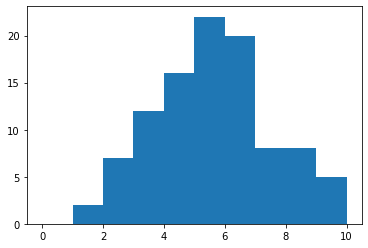

In [4]:
plt.hist(z, bins=np.arange(11));

In [5]:
data = np.column_stack([N, z])
header = "N z"
np.savetxt('flip_data.txt', data, fmt='%i', header=header, comments='')

# data = np.genfromtxt('./flip_data.txt', names=True)
# N = data['N']
# z = data['z']

## Single coin posterior

First let's recall what the typical uncertainty is when inferring the bias of a single coin from 10 flips with a uniform prior.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 838.08it/s]


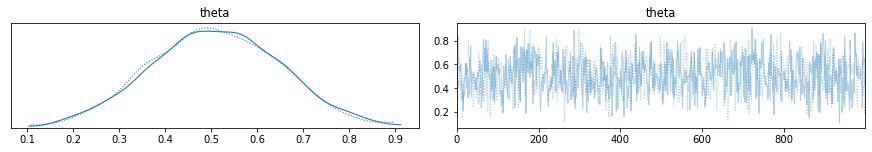

In [6]:
coin = 0
with pm.Model() as single_model:
    # define the hyperparameters
    theta = pm.Beta('theta', 1, 1)
    
    # define the likelihood
    y = pm.Binomial('y', n=N[coin], p=theta, observed=z[coin])
    trace = pm.sample(1000)
    pm.traceplot(trace)

## Single factory

Now let's model the coins as having come from a single factory producing coins in a beta distribution of unknown shape.  We'll start with a $\mathrm{beta}(\omega|A_\omega=2, B_\omega=2)$ prior on $\omega$, and $\mathrm{gamma}(\kappa|1, 0.4)$ prior on $\kappa$.

First a look at the prior distribution on $\kappa$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kappa]
Sampling chain 1, 4 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 782.05it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


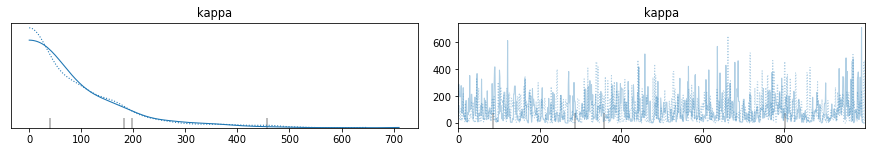

In [7]:
with pm.Model() as model:
    # define the hyperparameters
    kappa = pm.Gamma('kappa', 1, .01)
    trace = pm.sample(1000)
    pm.traceplot(trace)

Now for the full model:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, kappa, omega]
Sampling chain 1, 20 divergences: 100%|██████████| 2500/2500 [00:13<00:00, 181.97it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6607598179659856, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


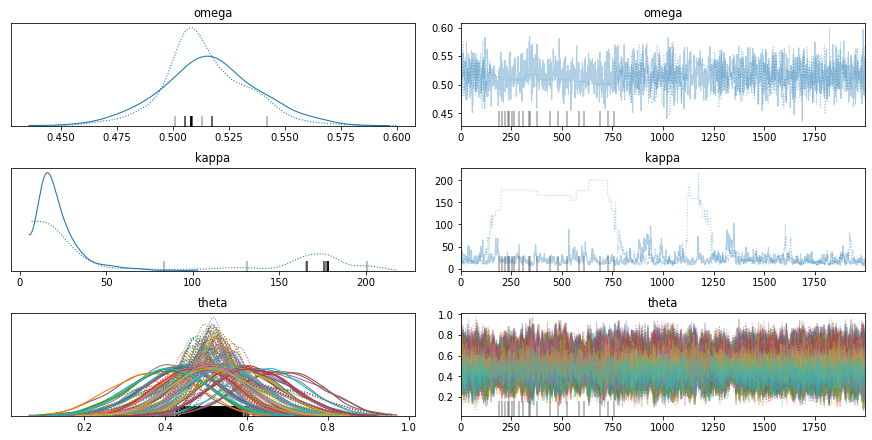

In [8]:
# Specify the model in PyMC
with pm.Model() as single_factory_model:
    ω = pm.Beta('omega', 2, 2)
    κ = pm.Gamma('kappa', 1, .01)
    
    # define the prior
    α = ω * (κ - 2) + 1
    β = (1 - ω) * (κ - 2) + 1
    θ = pm.Beta('theta', α, β, shape=len(N))
    
    # define the likelihood
    y = pm.Binomial('y', n=N, p=θ, observed=z)
    trace = pm.sample(2000)
    pm.traceplot(trace)

So assuming the coins came from a single factory, we find that the factory likely produces close=to-fair coins, with a fairly low concentration (i.e., coin biases are widely distributed about ~0.5).

Let's do some posterior predictive checking to see if our model and posterior reproduce similar data.

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1/1 [00:00<00:00, 95.48it/s]


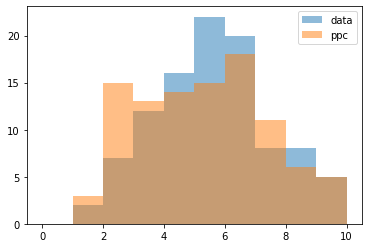

In [9]:
with single_factory_model:
    ppc = pm.sample_posterior_predictive(trace, samples=1)
plt.hist(z, bins=np.arange(11), label='data', alpha=0.5);
plt.hist(ppc['y'].flatten(), bins=np.arange(11), label='ppc', alpha=0.5)
plt.legend();

...close, but not particularly compelling.

## Two-factory model
Now let's model that data as having come from two factories, with unknown relative production rates and unknown bias distributions.

In [10]:
k = 2

# Specify the model in PyMC
with pm.Model() as model:
    # define the hyperparameters
    w = pm.Dirichlet('weight', a=np.ones(k), shape=k, testval=np.ones(k)/k)

    ω = pm.Beta('omega', 2, 2, shape=k, testval=np.linspace(.2, .8, k))
    κ = pm.Gamma('kappa', 1, .01, shape=k)

    # Reject proposals to swap the ordering of the factory modes
    switch = pm.math.switch(ω[1] - ω[0] < 0, -np.inf, 0)
    order_mode_potential = pm.Potential('order_mode_potential', switch)

    # latent subpopulation association of each observation
    factory = pm.Categorical('factory', p=w, shape=len(N))
    
    # define the prior
    α = ω[factory] * (κ[factory] - 2) + 1
    β = (1 - ω[factory]) * (κ[factory] - 2) + 1
    θ = pm.Beta('theta', α, β, shape=len(N))
    
    # define the likelihood
    y = pm.Binomial('y', n=N, p=θ, observed=z)

In [11]:
with model:
    trace = pm.sample(1000, tune=2000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [theta, kappa, omega, weight]
>BinaryGibbsMetropolis: [factory]
Sampling chain 1, 95 divergences: 100%|██████████| 3000/3000 [02:15<00:00, 22.13it/s]
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7062157942225388, but should be close to 0.8. Try to increase the number of tuning steps.
There were 589 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7186333992178391, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


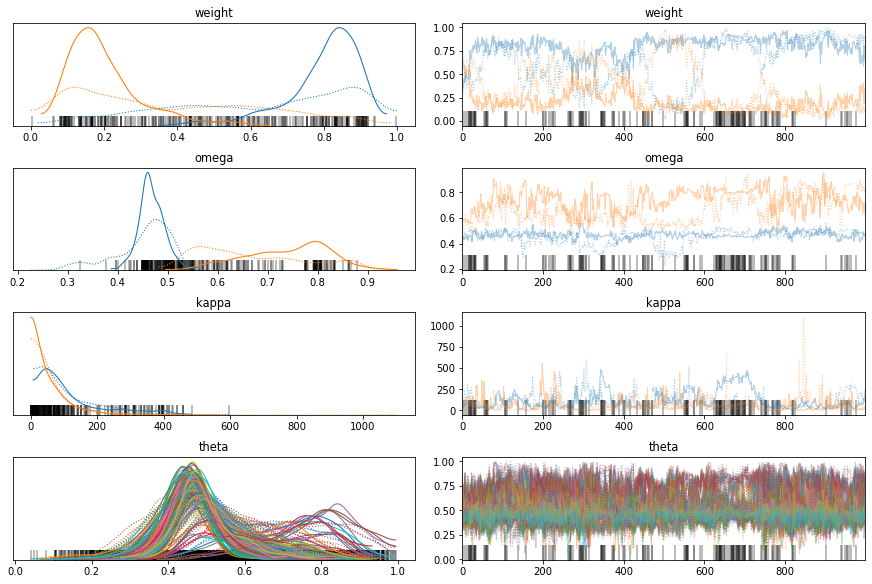

In [12]:
pm.traceplot(trace, ['weight', 'omega', 'kappa', 'theta']);

We definitely need to collect more steps or tweak tuning setting to have robust posterior samples, but this is good enough for our purporses.  We recover weights indicating one factory is responsible for ~80% of the coins, and that dominant factory produces coins that are close to fair with a pretty high concentration.  The other factory produces very bias coins, with low concentation.

First a posterior predictive check.

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1/1 [00:00<00:00, 99.77it/s]


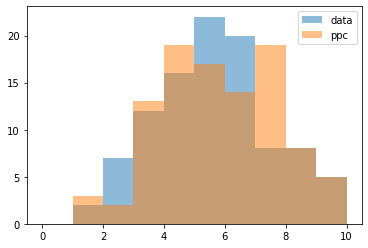

In [13]:
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1)
plt.hist(z, bins=np.arange(11), label='data', alpha=0.5);
plt.hist(ppc['y'].flatten(), bins=np.arange(11), label='ppc', alpha=0.5)
plt.legend();

Now let's take a look at the distribution of coins we infer each factory to be producing.

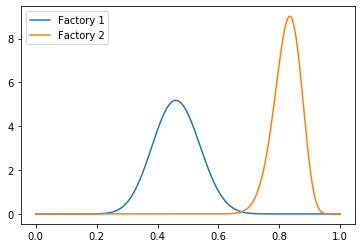

In [19]:
mean_omega = np.mean(trace['omega'], axis=0)
mean_kappa = np.mean(trace['kappa'], axis=0)

thetas = np.linspace(0, 1, 500)
a = trace['omega'] * (trace['kappa'] - 2) + 1
b = (1 - trace['omega']) * (trace['kappa'] - 2) + 1

idx = np.random.choice(len(trace['omega']))
for fac in np.arange(k):
    plt.plot(thetas, beta.pdf(thetas, a[idx, fac], b[idx, fac]), label='Factory {}'.format(fac+1));
plt.legend();